In [1]:
# TASKS
# TODO 1. Compare results for using early stopping and not using early stopping, maybe change the stopping criteria and the max patience
# TODO 2. Compare results for using 2 hidden layers as compared to only 1 (this will include a lot of coding changes, but sure helps in understanding the code better)
# TODO 3. Compare results for different hyperparameter values 
# TODO 4. Try to run a sweep locally on your machine using wandb, implementing grid search on chosen hyperparameters

In [2]:
import numpy as np 
import jax 
import jax.numpy as jnp
import time
from jax.example_libraries import optimizers
from sklearn.model_selection import train_test_split
from aux.ECG_utils import DummyArgs, ECGDataset, custom_collate_fn, init_weights_2layer
from aux.training_utils import run_epoch, j_v_prediction_per_sample
from torch.utils.data import DataLoader
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".70"

# parameters taken from the best-performing model after sweeping
args = DummyArgs()
print(args.__dict__)
args.batch_size = 256
args.lr = 0.002
args.tau_mem = 0.15
args.tau_mem_o = 0.01
args.num_hidden = 64
args.weight_gain = 0.4
args.seed = 0 
print(args.__dict__)

{'batch_size': 32, 'lr': 0.005, 'num_epochs': 1, 'tau_mem': 0.15, 'tau_mem_o': 0.1, 'Vth': 1, 'timestep': 0.002777777777777778, 'num_hidden': 64, 'weight_gain': 0.4, 'seed': 0}
{'batch_size': 256, 'lr': 0.002, 'num_epochs': 1, 'tau_mem': 0.15, 'tau_mem_o': 0.01, 'Vth': 1, 'timestep': 0.002777777777777778, 'num_hidden': 64, 'weight_gain': 0.4, 'seed': 0}


In [3]:
# Load delta modulated data
# binary classification
# # patient 208
X_train_dm, y_train = np.load('data/x_train_dm_208.npy'), np.load('data/y_train_dm_208.npy').astype(int) # patient 208
X_test_dm, y_test = np.load('data/x_test_dm_208.npy'), np.load('data/y_test_dm_208.npy').astype(int) # patient 208

# split the data into train, validation
X_train_dm, X_val_dm, y_train, y_val = train_test_split(X_train_dm, y_train, test_size=0.1, random_state=42)

# print shapes of X_train, X_val, X_test
print(f'\nX_train_dm shape: {X_train_dm.shape},\nX_val_dm shape: {X_val_dm.shape},\nX_test_dm shape: {X_test_dm.shape}')


X_train_dm shape: (2459, 250, 4),
X_val_dm shape: (274, 250, 4),
X_test_dm shape: (304, 250, 4)


In [4]:
# print class distribution
print(f'\nTrain class distribution: {np.unique(y_train, return_counts=True)}')
print(f'Val class distribution: {np.unique(y_val, return_counts=True)}')
print(f'Test class distribution: {np.unique(y_test, return_counts=True)}')


Train class distribution: (array([0, 1]), array([1298, 1161]))
Val class distribution: (array([0, 1]), array([131, 143]))
Test class distribution: (array([0, 1]), array([156, 148]))


In [5]:
train_loader = DataLoader(ECGDataset(X_train_dm, y_train),
                          batch_size=args.batch_size, shuffle=True, 
                          collate_fn=custom_collate_fn, drop_last=True)
val_loader = DataLoader(ECGDataset(X_val_dm, y_val), batch_size=args.batch_size, 
                        shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(ECGDataset(X_test_dm, y_test), batch_size=args.batch_size, 
                         shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

In [6]:
# initialize the weights

out_binary = 2

key = jax.random.PRNGKey(0)
key, w_original = init_weights_2layer(key, 4, args.num_hidden, out_binary, args.weight_gain)

# initialize the optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=args.lr)
opt_state = opt_init(w_original)

In [7]:
early_stopping = True

In [8]:
def train(hyperparams, n_epochs, opt_state, get_params, opt_update):

    print(f'batch_size = {args.batch_size}')
    key = jax.random.PRNGKey(0)
    best_train_acc = 0.000001
    best_train_f1 = 0.000001
    max_patience = 60
    patience = 0  # Early stopping
    print(f'{"Epoch": <6} | '
          f'{"Train loss": <15} | '
          f'{"Train acc": <15} | '
          f'{"Val acc": <15} | '
          f'{"Test acc": <15} | '
          f'{"Test Precision": <15} | '
          f'{"Test Recall": <15} | '
          f'{"Test F1": <15} | '
          f'{"Time": <15}')
    for e in range(n_epochs):
        epoch_start = time.time()
        key, opt_state, train_loss, train_acc, train_prec, train_rec, train_f1 = (
            run_epoch(key, train_loader, hyperparams, opt_state, get_params, 
                      e, opt_update)
        )
        key, _, val_loss, val_acc, val_prec, val_rec, val_f1 = (
            run_epoch(key, val_loader, hyperparams, opt_state, get_params)
        )
        time_epoch = time.time()
    
        key_test = jax.random.PRNGKey(0)
        _, _, test_loss, test_acc, test_prec, test_rec, test_f1 = (
            run_epoch(key_test, test_loader, hyperparams, opt_state, get_params)
        )
        if early_stopping and (train_acc > best_train_acc or train_f1 > best_train_f1):
            if ((train_acc - best_train_acc)/best_train_acc < 0.01 and train_acc > best_train_acc) or (train_f1 > best_train_f1 and (train_f1 - best_train_f1)/best_train_f1 < 0.01):
                patience += 1
                if patience == max_patience:
                    print(f'Early stopping at epoch {e}')
                    break
            else:
                best_train_acc = train_acc
                best_train_f1 = train_f1
                
                w_best = get_params(opt_state)
                opt_state_best = opt_state
                patience = 0
                #key_test 
                #jnp.save(f'weights/w_best.npy', w_best)    
            if e % 10 == 0:
                print(f'{e : <6} | '
                        f'{train_loss:.4f}{"":<9} | '
                        f'{train_acc:.4f}{"":<9} | '
                        f'{val_acc:.4f}{"":<9} | '
                        f'{test_acc:.4f}{"":<9} | '
                        f'{test_prec:.4f}{"":<9} | '
                        f'{test_rec:.4f}{"":<9} | '
                        f'{test_f1:.4f}{"":<9} | '
                        f'{time_epoch - epoch_start:.2f}{"":<9} | '
                        f'{patience:.2f}')
        else:
            if e % 10 == 0:
                print(f'{e : <6} | '
                        f'{train_loss:.4f}{"":<9} | '
                        f'{train_acc:.4f}{"":<9} | '
                        f'{val_acc:.4f}{"":<9} | '
                        f'{test_acc:.4f}{"":<9} | '
                        f'{test_prec:.4f}{"":<9} | '
                        f'{test_rec:.4f}{"":<9} | '
                        f'{test_f1:.4f}{"":<9} | '
                        f'{time_epoch - epoch_start:.2f}{"":<9} | '
                        f'{patience:.2f}')
            if early_stopping:
                    patience += 1
                    if patience == max_patience:
                        print(f'Early stopping at epoch {e}')
                        break
            
    return best_train_acc, opt_state, get_params, best_train_acc, train_loss, train_acc, val_acc, test_acc, test_prec, test_rec, test_f1, patience

In [9]:
hyperparams = (args.tau_mem, args.tau_mem_o, args.Vth, args.timestep)
_, opt_state, get_params, best_train_acc, train_loss, train_acc, val_acc, test_acc, test_prec, test_rec, test_f1, patience = train(hyperparams, 301, opt_state, get_params, opt_update)

batch_size = 256
Epoch  | Train loss      | Train acc       | Val acc         | Test acc        | Test Precision  | Test Recall     | Test F1         | Time           
0      | 0.9795          | 0.7040          | 0.7656          | 0.8711          | 0.8769          | 0.8726          | 0.8709          | 1.03          | 0.00
10     | 0.4766          | 0.9193          | 0.9141          | 0.9570          | 0.9613          | 0.9560          | 0.9568          | 0.28          | 3.00
20     | 0.3833          | 0.9106          | 0.8906          | 0.9414          | 0.9486          | 0.9400          | 0.9410          | 0.27          | 13.00
30     | 0.3166          | 0.9240          | 0.9102          | 0.9609          | 0.9645          | 0.9600          | 0.9608          | 0.27          | 2.00
40     | 0.2871          | 0.9319          | 0.9180          | 0.9609          | 0.9645          | 0.9600          | 0.9608          | 0.27          | 12.00
50     | 0.2631          | 0.9379          | 0.906

# Debug

In [10]:
from aux.debug import plot_net, out_debug
batch_spikes, batch_labels = next(iter(test_loader))

In [11]:
w = get_params(opt_state)
*state, out, loss, pred = (
    out_debug(batch_spikes, batch_labels, hyperparams, w)
)

(S_h1, I_h1, V_h1), (S_h2, I_h2, V_h2), (S_o, I_o, V_o) = state[0]

# print shapes
print(f'batch_spikes shape: {batch_spikes.shape}, batch_labels shape: {batch_labels.shape}')
print(f'S_h1 shape: {S_h1.shape}, I_h1 shape: {I_h1.shape}, V_h1 shape: {V_h1.shape}')
print(f'S_h2 shape: {S_h2.shape}, I_h2 shape: {I_h2.shape}, V_h2 shape: {V_h2.shape}')
print(f'S_o shape: {S_o.shape}, I_o shape: {I_o.shape}, V_o shape: {V_o.shape}')
print(f'out shape: {out.shape}, loss shape: {loss.shape}, pred shape: {pred.shape}')

# print pred
offset = 50
print(f'\npred: {pred[offset:(offset+25)]}')
print(f'lbls: {batch_labels[offset:(offset+25)]}')
print(f'same: {np.equal(pred, batch_labels)[offset:(offset+25)].astype(int)}')

# print manual accuracy
print(f'\nmanual accuracy: {np.mean(np.equal(pred, batch_labels))}')

loss: 0.09719714522361755, acc: 0.984375
batch_spikes shape: (256, 250, 4), batch_labels shape: (256,)
S_h1 shape: (256, 250, 64), I_h1 shape: (256, 250, 64), V_h1 shape: (256, 250, 64)
S_h2 shape: (256, 250, 32), I_h2 shape: (256, 250, 32), V_h2 shape: (256, 250, 32)
S_o shape: (256, 250, 2), I_o shape: (256, 250, 2), V_o shape: (256, 250, 2)
out shape: (256, 2), loss shape: (), pred shape: (256,)

pred: [0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1]
lbls: [0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1]
same: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]

manual accuracy: 0.984375


w_original[0] == w[0]: False
loss: 0.6951932907104492, acc: 0.5390625
loss: 0.09719714522361755, acc: 0.984375


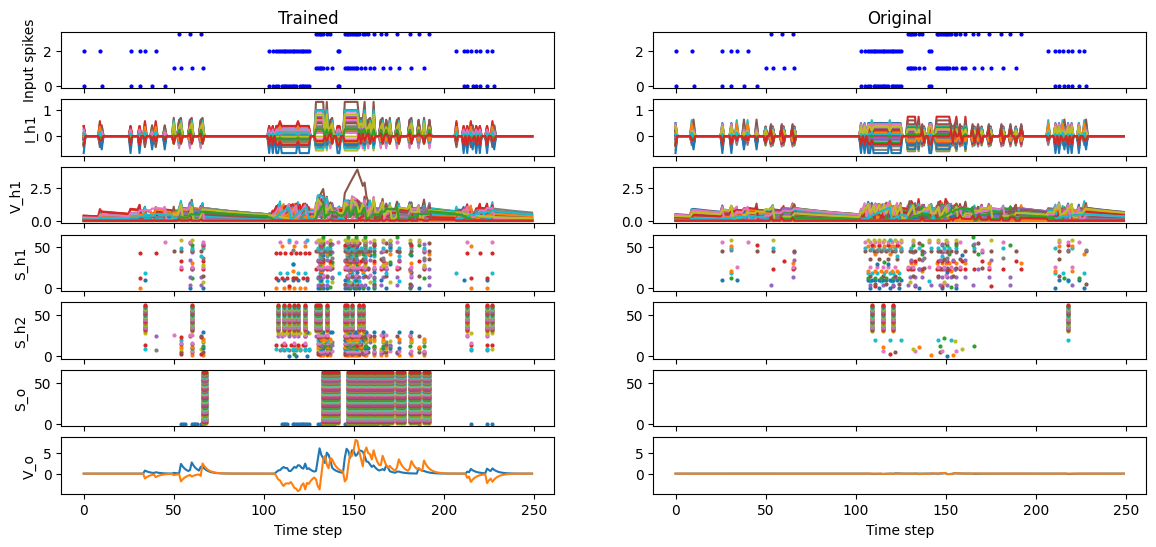

In [12]:
plot_net(get_params(opt_state), w_original, batch_spikes, batch_labels, hyperparams, 12)

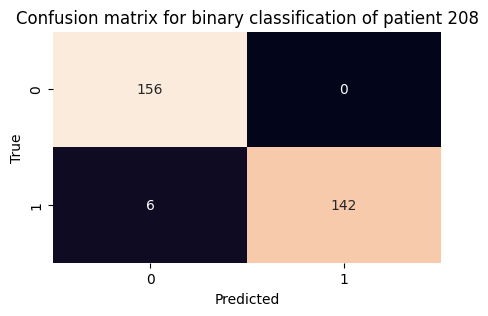


Class  | Recall   | Precision | Specificity | F1    
0      | 1.000000 | 0.9629630 | 0.959459459 | 0.981132
1      | 0.959459 | 1.0000000 | 1.000000000 | 0.979310

accuracy: 0.9802631578947368


In [13]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

state = j_v_prediction_per_sample(get_params(opt_state), X_test_dm, hyperparams)
V_mem = state[2][2]
#print(V_mem.shape) # (batch_size, sim_len ,out_dim)
max_per_class = jnp.max(V_mem, axis=1)
#print(max_per_class.shape)
y_pred = jnp.argmax(max_per_class, axis=1)
#print(y_pred)

# plot normalized confusion matrix manually without sklearn
cm = np.zeros((out_binary, out_binary))
for i in range(len(y_pred)):
    cm[y_test[i], y_pred[i]] += 1
#cm = cm / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [i for i in range(out_binary)], columns = [i for i in range(out_binary)])
plt.figure(figsize = (5,3))
sns.heatmap(df_cm, annot=True, fmt='g', cbar=False) # cmap='Blues'
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for binary classification of patient 208')
plt.show()

# print f1, precision, recall without classification report
precision = np.zeros(out_binary)
recall = np.zeros(out_binary)
specificity = np.zeros(out_binary)
f1 = np.zeros(out_binary)

# formula for specificity 
# specificity = TN / (TN + FP) = TN / N = 1 - FPR

for i in range(out_binary):
    precision[i] = cm[i,i] / cm[:,i].sum() if cm[:,i].sum() != 0 else np.nan
    recall[i] = cm[i,i] / cm[i,:].sum() if cm[i,:].sum() != 0 else np.nan
    # calculate specificity
    TN = cm[:i,:i].sum() + cm[i+1:,i+1:].sum()
    FP = cm[:i,i].sum() + cm[i+1:,i].sum()
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else np.nan
    f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else np.nan

# print recall, precision, specificity, f1 in a table for each class
print(f'\n{"Class": <6} | {"Recall": <8} | {"Precision": <9} | {"Specificity": <9} | {"F1": <6}')
for i in range(out_binary):
    print(f'{i : <6} | {recall[i]:.6f} | {precision[i]:.7f} | {specificity[i]:.9f} | {f1[i]:.6f}')


# print(f'recall - SEN: {recall}')
# print(f'precision - PPV: {precision}')
# print(f'specificity - SPEC: {specificity}')
# print(f'f1: {f1}')

# print ovreall accuracy
accuracy = np.mean(np.equal(y_pred, y_test))
print(f'\naccuracy: {accuracy}')

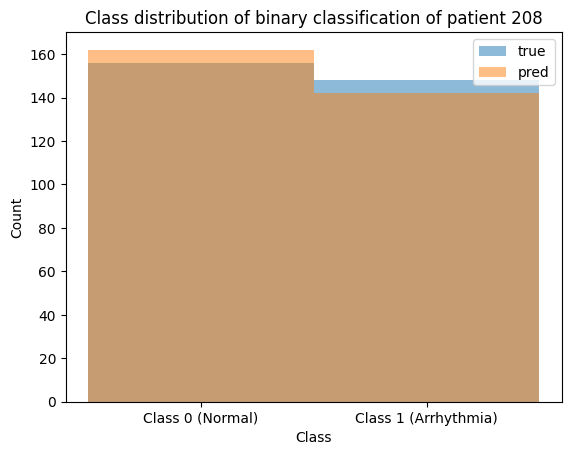

In [14]:
# plot class distribution of dataset used for confusion matrix 
plt.hist(y_test, bins=out_binary, alpha=0.5, label='true')
plt.hist(y_pred, bins=out_binary, alpha=0.5, label='pred')
plt.ylabel('Count')
plt.xlabel('Class')
# label x-axis: 0 - normal, 1 - abnormal
plt.xticks([0.25, 0.75], ['Class 0 (Normal)', 'Class 1 (Arrhythmia)'])
plt.title('Class distribution of binary classification of patient 208')
plt.legend(loc='upper right')
plt.show()

In [16]:
# get weights
w = get_params(opt_state)
run_id = 'run0001'

# save weights of current model in for loop
for i in range(len(w)):
    #if file does nor exist, create one
    if not os.path.exists('weights'):
        os.makedirs('weights')
    jnp.save(f'weights/'+run_id+'_w_'+str(i)+'.npy', w[i])


5
